<img src="../../../images/qiskit_header.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

# Calibrating a Qubit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from qiskit import IBMQ
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble


### Loading pulse backend
To run an OpenPulse experiment, at first we need to load a backend object of your quantum computing system with `open_pulse = True`. Then, you need  to create a `PulseChannelSpec` object from the backend. This object will give you a data set to create a pulse schedule object.

- `system.drives` : Returns a list of drive channels.
- `system.controls` : Returns a list of control channels.
- `system.measures` : Returns a list of measurement channels.
- `system.acquires` : Returns a list of acquire channels.
- `system.registers` : Returns a list of registers.
- `system.memoryslots` : Returns a list of memory slots.

Mapping between these channels and qubits is automatically created in the `PulseChannelSpec` instance.

- `system.qubits` : Returns a list of qubit object.

Each qubit object comprises `.drive`, `.controls`, and `.measure` channels, which are associated with the qubit.

In this example we use IBMQ Poughkeepsie, a 20 qubit client-only system.

In [2]:
IBMQ.load_account()
ibmq_provider = IBMQ.get_provider(
    hub='provide_your_hub_name_here',
    group='provide_your_group_name_here',
    project='provide_your_project_name_here'
)
backend = ibmq_provider.get_backend(
    'ibmq_poughkeepsie'
)

system = pulse.PulseChannelSpec.from_backend(backend)

In [3]:
config = backend.configuration()
defaults = backend.defaults()

### Create pulses

User defined pulses can be created by using the `pulse.function` decorator. A python callback function which returns an `array_like` object can be used to create pulses. The first argument of the function should be `duration` specifing the number of data points. You are also able to get standard pulse templates from `pulse_lib`, and able to find calibrated pulses provided by the backend in `CmdDef`. In this notebook, we use a Gaussian pulse template from `pulse_lib.gaussian` and default measurement pulses from `CmdDef`.

In [4]:
cmd_def = pulse.CmdDef.from_defaults(defaults.cmd_def, defaults.pulse_library)

measure = cmd_def.get('measure', qubits=config.meas_map[0])

In [5]:
# Calculate amplitude from complex signal
def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)

In this notebook, we apply the backend default setting for drive and measurement pulse frequency. These frequencies are calibrated to be centered at resonanse frequency of corresponding qubit and readout resonator. To change this setting, you can refer to the [qiskit community tutorials](https://github.com/Qiskit/qiskit-community-tutorials).

## _Running Rabi Experiment_

In this experiment, we apply a Rabi drive pulse to qubit0 and measure a signal from the qubit by changing the amplitude of the pulse (`drive_amps`) from 0 to 0.05. The returned signal is integrated and averaged over 512 shot. A `boxcar` kernel is used to process measurement data (**note**: currently the hardware overrides this specification, to be implemented in future versions). The result is stored in `memory_slot[0]`.

In [12]:
# qubit to use for exeperiment
qubit = 0

# exp configuration
exps = 64
shots = 512

# Rabi pulse
drive_amps = np.linspace(0, 0.05, exps)
drive_samples = 128
drive_sigma = 16

# scaling factor for data returned by system
scale_factor=1e-10

Pulse commands are registered to `Schedule`s with information of `channel` and `start_time`. The channel information is provided by `PulseChannelSpec`. You can create your `Schedule` by using syntax sugar:  

- `|` (`union`): combine two `Schedule`s in parallel.
- `+` (`append`): add a `Schedule` right after a `Schedule` to be appended.
- `<<` (`shift`): shift `start_time` of `Schedule`.

All details are available in [Pulse Schedules](../terra/5_pulse_schedules.ipynb).
Created `Schedule`s can be combined into a single job.

In [13]:
# Create schedule
schedules = []
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, sigma=drive_sigma, name='rabi_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule |= rabi_pulse(system.qubits[qubit].drive)
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)

We may plot any of the experiment schedules with:

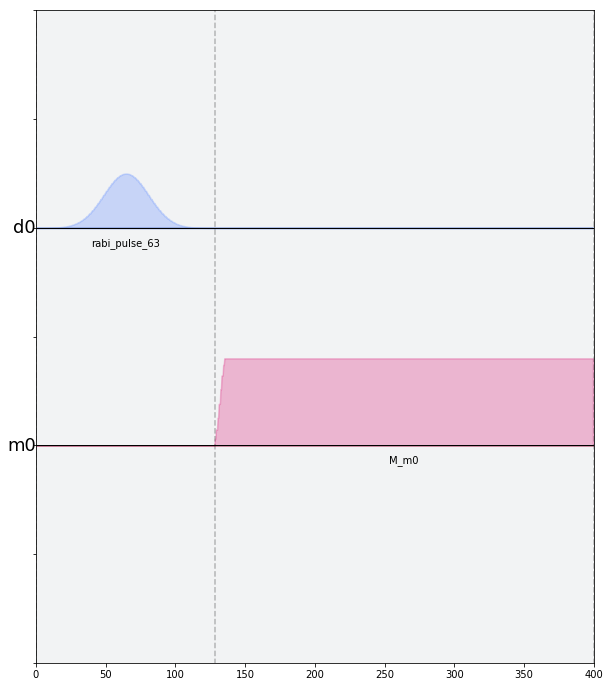

In [14]:
schedules[-1].draw(channels_to_plot=[system.qubits[qubit].measure, system.qubits[qubit].drive],
                   scaling=10.0, label=True, plot_range=(0, 400))

After `Schedule`s are now build for the Rabi experiment. We now assemble the Qobj to be sent to the quantum computing system. We use `meas_level=1` to get the default kernel integrated results from the system, and we automatically average them with `meas_return='avg'`.

In [15]:
rabi_qobj = assemble(schedules, backend, meas_level=1, meas_return='avg', shots=shots)

After building our rabi experiment Qobj we now submit it to the backend to be run.

In [16]:
job = backend.run(rabi_qobj)

We receive a job object for our experiment which we may be used to monitor and get the results of the experiment.

In [17]:
job.job_id()

'5d69e108edb7530011bcd1a1'

In [19]:
job.status()

<JobStatus.RUNNING: 'job is actively running'>

We now ask for the result from the quantum computing system, which will block until completion (or timeout).

In [20]:
rabi_result = job.result(timeout=3600)

### Analyze the result

The result for our experiment is stored in `memory_slot[qubit]`. The returned data are the integrated values of the received and mixed down stimulus signal applied to the measured resonator averaged over all shots. Looking at the signal amplitude, we will observe an oscillation of the signal as a function of the drive amplitude. This is known as a Rabi oscillation and correspond to the qubit being periodically driven to its excited state. This is how we control our qubits.

Below we extract the data from the returned system `memory`. 

In [21]:
qubit_rabi_data = np.ones(exps, dtype=np.complex_)
for i in range(exps):
    qubit_rabi_data[i] = rabi_result.get_memory(i)[qubit]*scale_factor

We now plot and fit the extracted signal to a sinusoid.

Pi Amplitude 0.016340


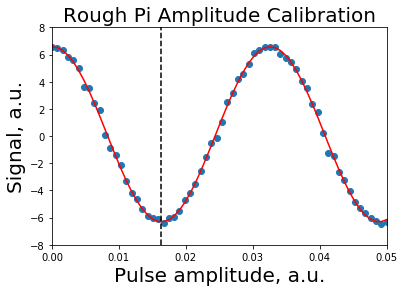

In [25]:
rabi_amp_data = get_amplitude(qubit_rabi_data)

fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)

#Fit the data
fitparams, conv = curve_fit(fit_func, drive_amps, rabi_amp_data, [7.0,0.0,0.03,0])

#get the pi amplitude
pi_amp = (np.pi-fitparams[3])*fitparams[2]/2/np.pi

plt.scatter(drive_amps, rabi_amp_data)
plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='red')
plt.axvline(pi_amp, color='black', linestyle='dashed')
plt.xlim(0, 0.05)
plt.ylim(-8, 8)
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('Rough Pi Amplitude Calibration', fontsize=20)

print('Pi Amplitude %f'%(pi_amp))

From the fit we obtain the Rabi oscillation frequency. We may use this to extract the amplitude of a $\pi$ pulse. This is the required amplitude to drive the qubit from the ground state ($|0\rangle$) to the excited state ($|1\rangle$).

## _Measuring the IQ Distribution from the 0 and 1 States_

In this experiment, we observe a change of measured signals depending on a quantum state of qubit0. By setting `drive_amp` to `pi_amp` we previously obtained, we can apply a $\pi$-pulse to the qubit0. To observe a distribution on the IQ plane, we set `meas_return` to `single` .

In [21]:
# Create schedule
rabi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                amp=pi_amp,
                                sigma=drive_sigma,
                                name='pi_pulse')
    
# excited
excited_exp = pulse.Schedule(name='pi_exp')
excited_exp |= rabi_pulse(system.qubits[qubit].drive)
excited_exp |= measure << rabi_pulse.duration

# ground
ground_exp = pulse.Schedule(name='no_pi_exp')
ground_exp |= measure << rabi_pulse.duration

excited_exp_schedules = [ground_exp, excited_exp]

In [84]:
excited_exp_qobj = assemble(excited_exp_schedules, backend, meas_level=1,
                            meas_return='single', shots=shots)

In [86]:
excited_exp_job = backend.run(excited_exp_qobj)

In [87]:
excited_exp_job.status()

<JobStatus.RUNNING: 'job is actively running'>

In [88]:
excited_exp_result = excited_exp_job.result(timeout=3600)

### Analyze the result

In [95]:
excited_exp_result.get_memory(0)[:, 0].shape

(512,)

In [97]:
ground_data = excited_exp_result.get_memory(0)[:, qubit]*scale_factor
excited_data = excited_exp_result.get_memory(1)[:, qubit]*scale_factor


Text(0, 0.5, 'Q (a.u.)')

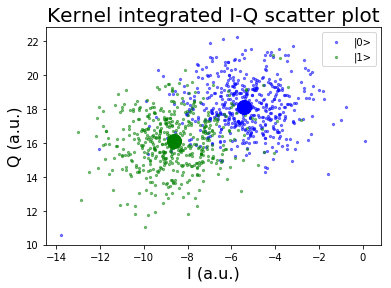

In [99]:
plt.scatter(np.real(ground_data), np.imag(ground_data), s=5, cmap='viridis',c='blue',alpha=0.5, label='|0>')
plt.scatter(np.real(excited_data), np.imag(excited_data), s=5, cmap='viridis',c='green',alpha=0.5, label='|1>')
ground_center = np.mean(ground_data)
excited_center = np.mean(excited_data)

plt.scatter(np.real(ground_center), np.imag(ground_center), c='blue', s=200, alpha=1.0)
plt.scatter(np.real(excited_center), np.imag(excited_center), c='green', s=200, alpha=1.0)

plt.title('Kernel integrated I-Q scatter plot', fontsize=20)
plt.legend(loc='upper right')
plt.xlabel('I (a.u.)', fontsize=16)
plt.ylabel('Q (a.u.)', fontsize=16)

# Measuring CR Rabi oscillation

In this section, we measure cross resonance Rabi oscillation on qubit0 and qubit1. The basic idea of cross resonance is applying a microwave pulse to a control qubit, but the pulse frequency is identical to a resonance frequency of target qubit. Because the oscillator frequency of drive channel used in previous experiments is adjusted to be at the resonance frequency of corresponding qubit, a cross resonance pulse should be applied from another channel to have different oscillator frequency. This is realized by a control channel (`U channel`) in this experiment.  
It is to be noted that a role of control channels is not only applying CR pulses, but also anything as described in `config.hamiltonian`, and it strongly depends on the design of quantum computing system.

In [26]:
# qubit to use for exeperiment
control_qubit = 0
target_qubit = 1
uchannel = 0

# exp configuration
exps = 30
shots = 512

# Rabi pulse
cr_amps = np.linspace(0, 0.2, exps)
cr_samples = 200
cr_sigma = 4
cr_rise_fall = 16

You can check if your control qubit and target qubit are connected by bus

In [27]:
[control_qubit, target_qubit] in config.coupling_map

True

Usually we use a qubit with higher frequency as a control.

In [28]:
defaults.qubit_freq_est[control_qubit] > defaults.qubit_freq_est[target_qubit]

True

For above qubit configuration, control channel 0 is available to realize CR pulse. For other configurations, you can refere to `CmdDef` to find proper control channel index.

In [29]:
config.u_channel_lo[uchannel]

[UchannelLO(q=1, scale=(1+0j))]

In this experiment, we use two pulse echoed CR sequence to eliminate unwanted interaction.

In [30]:
# Create schedule
schedules = []
for ii, cr_amp in enumerate(cr_amps):
    # drive pulse
    cr_rabi_pulse_p = pulse_lib.gaussian_square(duration=cr_samples,
                                                amp=cr_amp,
                                                sigma=cr_sigma,
                                                risefall=cr_rise_fall,
                                                name='cr_rabi_pulse_p%d' % ii)
    cr_rabi_pulse_m = pulse_lib.gaussian_square(duration=cr_samples,
                                                amp=-cr_amp,
                                                sigma=cr_sigma,
                                                risefall=cr_rise_fall,
                                                name='cr_rabi_pulse_m%d' % ii)
    pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                  amp=pi_amp,
                                  sigma=drive_sigma,
                                  name='pi_pulse')
    
    # add commands to schedule
    schedule = pulse.Schedule(name='CR Rabi Experiment at drive amp = %s' % cr_amp)
    
    schedule |= cr_rabi_pulse_p(system.controls[uchannel])
    schedule |= pi_pulse(system.qubits[control_qubit].drive) << schedule.duration
    schedule |= cr_rabi_pulse_m(system.controls[uchannel]) << schedule.duration
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)

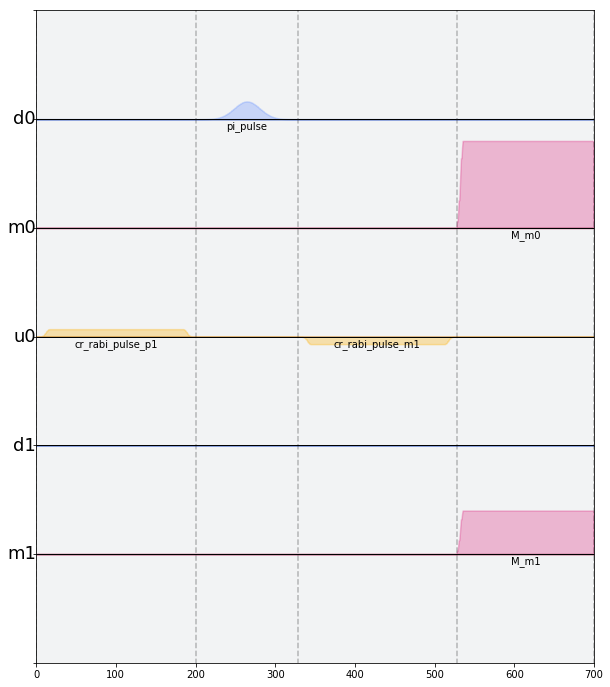

In [31]:
schedules[1].draw(channels_to_plot=[system.qubits[control_qubit].drive,
                                    system.qubits[target_qubit].drive,
                                    system.qubits[control_qubit].measure,
                                    system.qubits[target_qubit].measure,
                                    system.controls[uchannel]],
                   scaling=20.0, label=True, plot_range=(0, 700))

In [32]:
cr_rabi_qobj = assemble(schedules, backend, meas_level=1, meas_return='avg', shots=shots)

In [33]:
job = backend.run(cr_rabi_qobj)

In [37]:
job.job_id()

'5d69e89e45953e0012355f06'

In [38]:
job.status()

<JobStatus.RUNNING: 'job is actively running'>

In [39]:
cr_rabi_result = job.result(timeout=3600)

### Analyze the result

In [40]:
target_qubit_rabi_data = np.ones(exps, dtype=np.complex_)
control_qubit_rabi_data = np.ones(exps, dtype=np.complex_)

for i in range(exps):
    target_qubit_rabi_data[i] = cr_rabi_result.get_memory(i)[target_qubit]*scale_factor
    control_qubit_rabi_data[i] = cr_rabi_result.get_memory(i)[control_qubit]*scale_factor

You can observe oscillation of measured signal only of the target qubit.

Text(0.5, 1.0, 'CR Rabi oscillation')

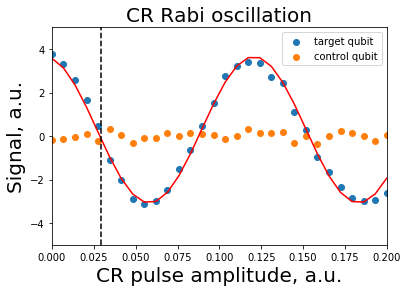

In [41]:
target_rabi_amp_data = get_amplitude(target_qubit_rabi_data)
control_rabi_amp_data = get_amplitude(control_qubit_rabi_data)

fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)

#Fit the data
fitparams, conv = curve_fit(fit_func, cr_amps, target_rabi_amp_data, [3.0,0.0,0.1,0])

#get the pi amplitude
cr_pi_2_amp = (np.pi-fitparams[3])*fitparams[2]/4/np.pi

plt.plot(cr_amps, fit_func(cr_amps, *fitparams), color='red')
plt.axvline(cr_pi_2_amp, color='black', linestyle='dashed')
plt.scatter(cr_amps, target_rabi_amp_data, label='target qubit')
plt.scatter(cr_amps, control_rabi_amp_data, label='control qubit')
plt.xlim(0, 0.2)
plt.ylim(-5, 5)
plt.legend()
plt.xlabel('CR pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('CR Rabi oscillation', fontsize=20)

From the fit we obtain the CR Rabi oscillation frequency. We may use this to extract the amplitude of a CR π/2 pulse, which is the foundation of the CNOT gate.

In [42]:
cr_pi_2_amp

0.029068217547629217

In [2]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright